Branch "wind_vs_wind_stress"

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

GPU Ocean-modules:

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, Observation, WindStress
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler gpu_ctx_wind0

In [5]:
%cuda_context_handler gpu_ctx_wind1

In [6]:
%cuda_context_handler gpu_ctx_wind2

In [7]:
%cuda_context_handler gpu_ctx_wind3

In [8]:
%cuda_context_handler gpu_ctx_wind4

In [9]:
%cuda_context_handler gpu_ctx_wind5

In [10]:
%cuda_context_handler gpu_ctx_wind6

In [11]:
%cuda_context_handler gpu_ctx_wind7

In [12]:
%cuda_context_handler gpu_ctx_wind8

In [13]:
%cuda_context_handler gpu_ctx_wind9

In [14]:
%cuda_context_handler gpu_ctx_wind10

In [15]:
%cuda_context_handler gpu_ctx_wind11

In [16]:
gpu_ctx_winds = [gpu_ctx_wind0, gpu_ctx_wind1, gpu_ctx_wind2, gpu_ctx_wind3, gpu_ctx_wind4, gpu_ctx_wind5, gpu_ctx_wind6, gpu_ctx_wind7, gpu_ctx_wind8, gpu_ctx_wind9, gpu_ctx_wind10, gpu_ctx_wind11]

In [17]:
nx = 100
ny = 100

dx = 100.0
dy = 100.0

dt = 0.0
g = 9.81
f = 0.0
r = 0.0

ghosts = [2,2,2,2] # north, east, south, west

dataShape = (ny + ghosts[0] + ghosts[2], nx + ghosts[1] + ghosts[3])

eta0 = np.zeros(dataShape, dtype=np.float32)
hu0 = np.zeros(dataShape, dtype=np.float32)
hv0 = np.zeros(dataShape, dtype=np.float32)
Hi = 10 * np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')

boundary_conditions = Common.BoundaryConditions(2,2,2,2)

T = 600

In [18]:
wind_t = np.array([0])
wind_u = [np.array([[ 0]])]
wind_v = [np.array([[ 0]])]

In [19]:
wind = WindStress.WindStress(t=wind_t, wind_u=np.float32(wind_u), wind_v=np.float32(wind_v))

In [20]:
sim = CDKLM16.CDKLM16(gpu_ctx, \
                        eta0, hu0, hv0, Hi, \
                        nx, ny, \
                        dx, dy, dt, \
                        g, f, r, \
                        boundary_conditions=boundary_conditions,
                        wind=wind)

In [21]:
N_winds = 12

In [22]:
import pandas as pd 
forecasts = N_winds*[pd.DataFrame(columns=["time","pos_x", "pos_y"])]

In [23]:
wind4drifters = []
for i in range(N_winds):
    wind4drifters.append( WindStress.WindStress(t=wind_t, wind_u=np.float32([np.array([[np.sin(2*np.pi/N_winds*i)]])]), wind_v=np.float32([np.array([[np.cos(2*np.pi/N_winds*i)]])])) )

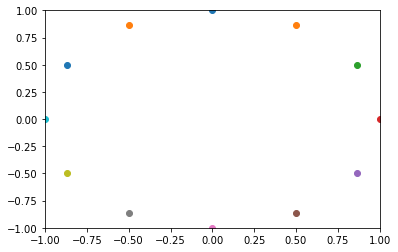

In [24]:
for i in range(N_winds):
    plt.scatter(wind4drifters[i].wind_u[0][0][0],wind4drifters[i].wind_v[0][0][0])
    plt.xlim([-1,1])
    plt.ylim([-1,1])

In [25]:
drifterSets = []
for i in range(N_winds):
    drifterSets.append( GPUDrifterCollection.GPUDrifterCollection( gpu_ctx_winds[i], 1, 
                                                 wind = wind4drifters[i], wind_drift_factor=0.02,
                                                 boundaryConditions = sim.boundary_conditions,
                                                 domain_size_x =  sim.nx*sim.dx,
                                                 domain_size_y =  sim.ny*sim.dy,
                                                 gpu_stream = sim.gpu_stream) )
    drifterSets[i].setDrifterPositions([[int(0.5*ny*dy),int(0.5*ny*dy)]])
    drifter_positions = drifterSets[i].getDrifterPositions()[0]
    forecasts[i] = forecasts[i].append({"time":sim.t, "pos_x":drifter_positions[1], "pos_y":drifter_positions[0]}, ignore_index=True)

In [26]:
for min in range(T):
    dt = 1
    sim.step(dt)
    for i in range(N_winds):
        drifterSets[i].drift(sim.gpu_data.h0, sim.gpu_data.hu0, sim.gpu_data.hv0, \
                        sim.bathymetry.Bm, sim.nx, sim.ny, sim.t, sim.dx, sim.dy, \
                        dt, np.int32(2), np.int32(2))
        drifter_positions = drifterSets[i].getDrifterPositions()[0]
        forecasts[i] = forecasts[i].append({"time":sim.t, "pos_x":drifter_positions[0], "pos_y":drifter_positions[1]}, ignore_index=True)

In [27]:
drifter_pathes = []
for i in range(N_winds):
    drifter_pathes.append( [forecasts[i]["pos_x"].to_numpy(), forecasts[i]["pos_y"].to_numpy()] )


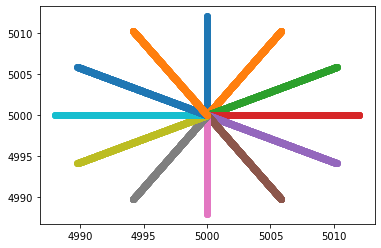

In [28]:
for i in range(N_winds):
    plt.scatter(drifter_pathes[i][0],drifter_pathes[i][1])